<a href="https://colab.research.google.com/github/amkayhani/DSML24/blob/main/5_1_BERT_Text_Classification_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab: Training and Evaluating a BERT Model for Text Classification

### Objective
In this lab, you will learn how to fine-tune a **BERT (Bidirectional Encoder Representations from Transformers) model** for text classification using the **IMDb dataset**. You will also evaluate its performance using standard classification metrics and visualize results with a confusion matrix.


### Step 1: Install Dependencies
Before proceeding, install the necessary Python libraries:

In [3]:
!pip install transformers datasets torch torchvision torchaudio scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Step 2: Load the IMDb Dataset
The IMDb dataset consists of **50,000** movie reviews labeled as **positive** or **negative**. We will use this dataset for binary sentiment classification.

In [4]:
from datasets import load_dataset
dataset = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Step 3: Tokenization with BERT
Before feeding text into BERT, it must be tokenized into **word pieces** and converted into **input IDs**.

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

### Step 4: Prepare Data for Training
Transform the dataset into a format compatible with PyTorch.
[(Tokenisation, padding and attension mask example)](https://github.com/amkayhani/DSML24/blob/main/5_2_bert_tokenisation_colab.ipynb)

In [ ]:
from torch.utils.data import random_split

# Rename column for compatibility
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Shuffle and select 10,000 samples
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))

# Define split sizes
train_size = int(0.6 * 10000)  # 60% for training
val_size = int(0.2 * 10000)    # 20% for validation
test_size = 10000 - train_size - val_size  # 20% for testing

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(shuffled_dataset, [train_size, val_size, test_size])


In [ ]:
print(train_dataset[0]) # Just to see paddings and attention masks(not necessary)

{'labels': tensor(0), 'input_ids': tensor([  101,  1045,  2031,  4961,  2039,  2007,  8040,  9541,  3762, 20160,
         2035,  2026,  2166,  1010,  2026,  3611,  3473,  2039,  2007,  8040,
         9541,  3762, 20160,  1012,  2057,  2031,  2074,  3427,  1996,  2034,
         2792,  1997,  1996, 19817, 21055,  3723,  2008,  4455,  2993, 25741,
         1998,  8040,  9541,  3762,  2131,  1037,  9789,  1012,  2054,  4774,
         2024,  6654, 10243,  2006,  4352,  2023, 25850, 13510,  2000,  2250,
         1012,  1996,  3494,  2071,  2031,  2042,  4567,  2488,  2011,  2026,
         3920,  2905,  1012,  1996,  2466,  2071,  2031,  2042,  2488,  2517,
         2011,  2026,  1017,  2095,  2214,  5519, 12334,  1006,  2040,  2024,
         8040,  9541,  3762, 20160,  4599,  2205,  1007,  1012,  8040,  9541,
         3762,  1998, 25741,  2074,  4995,  1005,  1056,   999,   999,   999,
          999,   999,  2065,  3087,  2021,  9036, 10556,  3366,  2213,  2515,
         1996,  2376,  1997, 

### Step 5: Load the Pre-trained BERT Model
We use a **pre-trained BERT model** with an additional **classification head**.

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 6: Define Performance Metrics
Compute accuracy, precision, recall, and F1-score.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

### Step 7: Define Training Parameters and Train the BERT Model

Configure training parameters using `TrainingArguments`.

🟢You will need to create an account to recieve the API key. Please follow the link on the code's output to create your account and receive the API key.

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs =3,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',
    logging_dir='./bert_logs',
    logging_steps=150,

)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,

)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: am_kayhani (am_kayhani-university-of-warwick) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.389700,0.306868,0.875000,0.922175,0.830134,0.873737
2,0.260800,0.348207,0.890000,0.934461,0.848369,0.889336
3,0.118300,0.424708,0.906500,0.899906,0.923225,0.911416


TrainOutput(global_step=2250, training_loss=0.295288513607449, metrics={'train_runtime': 424.5826, 'train_samples_per_second': 42.395, 'train_steps_per_second': 5.299, 'total_flos': 4735998996480000.0, 'train_loss': 0.295288513607449, 'epoch': 3.0})

### Step 8: Evaluate the Model

In [ ]:
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.4247084856033325, 'eval_accuracy': 0.9065, 'eval_precision': 0.8999064546304958, 'eval_recall': 0.9232245681381958, 'eval_f1': 0.9114163903363335, 'eval_runtime': 11.4539, 'eval_samples_per_second': 174.613, 'eval_steps_per_second': 5.5, 'epoch': 3.0}


### Step 9: Generate Predictions and Confusion Matrix

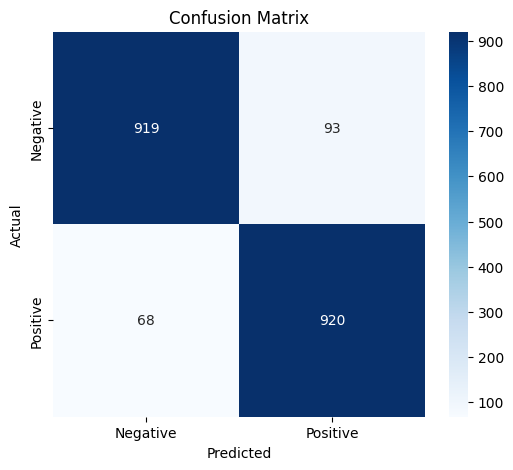

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
conf_matrix = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### **Exercise: Implementing Multi-Class Text Classification with BERT**

#### **Task 1: Data Preparation**
1. Load the **AG News dataset** and inspect the structure of the data.
2. Perform **tokenization** using the `BertTokenizer`.
3. Ensure proper **padding** and **truncation** for BERT input requirements.

In [10]:
from datasets import load_dataset
dataset = load_dataset("ag_news")




#### **Task 2: Model Fine-Tuning**
4. Load a **pre-trained BERT model** with a classification head.
5. Configure the training parameters such as batch size, learning rate, and number of epochs.
6. Train the model using the **Trainer API** from `transformers`.

#### **Task 3: Model Evaluation and Analysis**
7. Evaluate the model on the **test dataset** and compute accuracy, precision, recall, and F1-score.
8. Generate a **confusion matrix** to analyze misclassifications.
9. Interpret the confusion matrix and discuss the model's performance on different classes.

#### **Task 4: Experimentation and Improvements**
10. Modify the number of training epochs and observe the impact on accuracy.
11. Experiment with different **batch sizes** and evaluate training time versus model performance.
12. Consider using **learning rate scheduling** or **weight decay** to enhance model generalization.

### **Discussion Questions**
1. How many epochs is necessary to fine-tune an optimized model?
2. Is higher number of epocs always better?

### **Independent Learning Task**
- Train a BERT model on another **multi-class dataset** (e.g., DBpedia or Yahoo! Answers Topics).
- Compare the results with the AG News dataset and analyze the differences in classification performance.

In [ ]:
dataset = load_dataset("yahoo_answers_topics")
dataset = load_dataset("dbpedia_14")
